# Timing of lake drainages

In [1]:
# Load libraries
import sys
import sys
sys.path.append("../../../xapres_package/")
import ApRESDefs
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker 

import xarray as xr
import importlib
import pandas as pd
import math
from datetime import datetime, timedelta, date
from scipy.stats import linregress
import hvplot.xarray

from helpers import *

importlib.reload(ApRESDefs)
xa = ApRESDefs.xapres(loglevel='debug')

DEBUG    13:46:18 	 ApRESDefs.py @function _setup_logging line 615 - Stream logging level set to DEBUG
DEBUG    13:46:18 	 ApRESDefs.py @function _setup_logging line 616 - Add console handler to logger
DEBUG    13:46:18 	 ApRESDefs.py @function _setup_logging line 629 - File logging level set to DEBUG


In [2]:
# Load data
ds_11 = reload("A101")
ds_11 = ds_11.isel(time=range(20,len(ds_11.time))) # trim first few bursts, which were tests

ds_13 = reload("A103_fixed")
ds_13 = ds_13.isel(time=range(60,len(ds_13.time))) # trim first few bursts, which were tests

ds_14 = reload("A104")
ds_14 = ds_14.isel(time=range(50,len(ds_14.time))) # trim first few bursts, which were tests



In [3]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:46521")
client

<Client: 'tcp://127.0.0.1:46521' processes=4 threads=16, memory=125.80 GiB>

In [4]:
def strain_metrics(ds, win_cor, step, lag, noise_floor):
    # This function, given a window, and step, gives a total percentage of data that has high coherence
    b1 = ds.isel(time=range(0,len(ds)-lag))
    b2 = ds.isel(time=range(lag,len(ds)))
    dz, co, phi = xa.generate_range_diff(b1,b2,win_cor,step,None,0,0.95)
    dz=dz.assign(coherence=(['time','profile_range'],co))
    dz_new = dz.where(abs(dz.coherence) > 0.95).drop_duplicates('time')

    vv = dz_new.range_diff / dz_new.time_diff * 31536000
    vv_adjust = vv - vv.where(vv.profile_range<100).where(vv.profile_range > 50).mean(dim='profile_range')
    vv_err = dz_new.err / dz_new.time_diff * 31536000
    vv_mean_err = (vv_err.where(vv.profile_range<100).where(vv.profile_range > 50)**2).sum(dim='profile_range')/len(vv_err.profile_range.where(vv.profile_range<100,drop=True).where(vv.profile_range > 50,drop=True))
    vv_adjust_err = np.sqrt(vv_err**2 + vv_mean_err**2)

    fit=vv.where(vv.profile_range <=noise_floor).polyfit('profile_range',1,full=True)
    r2 = 1-fit.polyfit_residuals/((vv.where(vv.profile_range <=noise_floor)-vv.where(vv.profile_range <=noise_floor).mean())**2).sum(dim='profile_range')
    
    slope = fit.polyfit_coefficients.sel(degree=1)*vv.profile_range+fit.polyfit_coefficients.sel(degree=0)
    residual = vv-slope
    residual = residual.where(residual.profile_range <=noise_floor,drop=True)
    slope_errs = np.sqrt((1/(len(residual.profile_range)-2))*(((residual**2).sum(dim='profile_range'))/((residual.profile_range - residual.profile_range.mean())**2).sum()))

    int_err = slope_errs*np.sqrt(((vv.profile_range)**2).sum()/len(vv.profile_range))
    ds = vv.to_dataset(name='vv')
    ds['err'] = vv_err
    ds['slope']= fit.polyfit_coefficients.sel(degree=1)
    ds['intercept']=fit.polyfit_coefficients.sel(degree=0)
    ds['fit'] = slope
    ds['slope_err'] = slope_errs
    ds['int_err'] = int_err
    ds['vv_adjust'] = vv_adjust
    ds['vv_adjust_err'] = vv_adjust_err
    ds['doy_decimal'] =  ds.time.dt.dayofyear + (ds.time.dt.hour / 24) + (ds.time.dt.minute / 1440) + (ds.time.dt.second / 86400)
    return ds

def plot_fits(ds_15,ds_hour,xlims=False):
    fig, axs = plt.subplots(nrows=2,figsize=(15,10),sharex=True)
    axs[0].errorbar(ds_15.doy_decimal,ds_15.slope,yerr=ds_15.slope_err,marker='.',ecolor='k',label = '15 minute')
    axs[0].errorbar(ds_hour.doy_decimal,ds_hour.slope,yerr=ds_hour.slope_err,marker='.',ecolor='r',label = '1 hour')
    axs[0].legend()
    if xlims:
        axs[0].set_xlim(xlims)
    axs[0].set_ylabel('Strain rate [y$^{-1}$]')
    axs[0].set_title('Strain rate estimates')
    
    axs[1].errorbar(ds_15.doy_decimal,ds_15.intercept,yerr=ds_15.int_err,marker='.',ecolor='k',label = '15 minute intercept')
    axs[1].errorbar(ds_hour.doy_decimal,ds_hour.intercept,yerr=ds_hour.int_err,marker='.',ecolor='r',label = '1 hour intercept')
    axs[1].plot(ds_15.doy_decimal,ds_15.vv.where(ds_15.profile_range<100).mean(dim='profile_range'),linestyle='None',marker='.',label='15 minute mean vv')
    axs[1].plot(ds_hour.doy_decimal,ds_hour.vv.where(ds_hour.profile_range<100).mean(dim='profile_range'),linestyle='None',marker='.',label='1 hour mean vv')
    axs[1].legend()
    axs[1].set_title('Strain-fitting intercept and mean top-100 m vertical velocities')
    axs[1].set_ylabel('velocity [m y$^{-1}$]')
    axs[1].set_xlabel('DOY 2022')

def convert_to_doy(da):
    da['doy_decimal'] = da.time.dt.dayofyear + (da.time.dt.hour / 24) + (da.time.dt.minute / 1440) + (da.time.dt.second / 86400)
    return da


## Load A11 data

In [5]:
ds_11_drain = ds_11.isel(time=range(4200,5200))
test = custom_profile(ds_11_drain.isel(attenuator_setting_pair=0).chirp,clip_threshold=1.2,min_chirps = 5,start=20000)
time_to_interp = pd.date_range("2022-07-09 12:00", "2022-07-19 12:00", freq="15min")
interp_profiles = test.interp(time=time_to_interp,method='linear')
interp_profiles['doy_decimal'] = interp_profiles.time.dt.dayofyear + (interp_profiles.time.dt.hour / 24) + (interp_profiles.time.dt.minute / 1440) + (interp_profiles.time.dt.second / 86400)


In [6]:
a11_15 = strain_metrics(interp_profiles, 50, 50,1,800)
a11_hour = strain_metrics(interp_profiles, 50, 50,4,800)
a11_2hour = strain_metrics(interp_profiles, 50, 50,8,800)

/home/jovyan/xapres_package/notebooks/test_notes/strain_rates/../../../xapres_package/ApRESDefs.py:654: RuntimeWarning: invalid value encountered in divide
  c = top/bottom
/home/jovyan/xapres_package/notebooks/test_notes/strain_rates/../../../xapres_package/ApRESDefs.py:654: RuntimeWarning: invalid value encountered in divide
  c = top/bottom
/home/jovyan/xapres_package/notebooks/test_notes/strain_rates/../../../xapres_package/ApRESDefs.py:654: RuntimeWarning: invalid value encountered in divide
  c = top/bottom


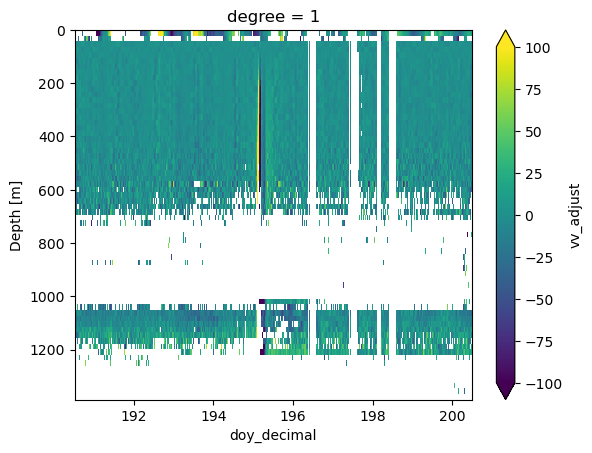

In [7]:
vv = convert_to_doy(a11_hour.vv_adjust)
vv.plot(x='doy_decimal',vmin=-100,vmax=100)
plt.gca().invert_yaxis()

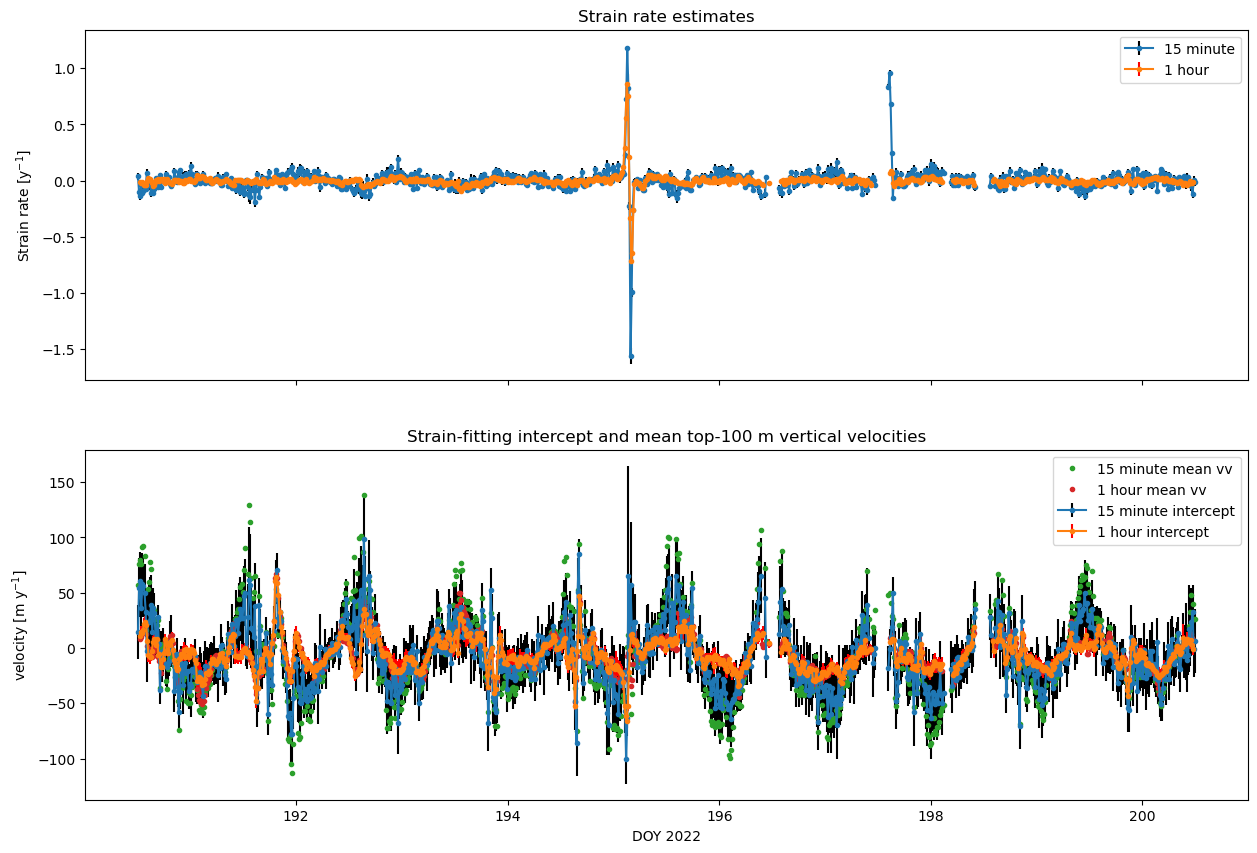

In [8]:
plot_fits(a11_15,a11_hour)

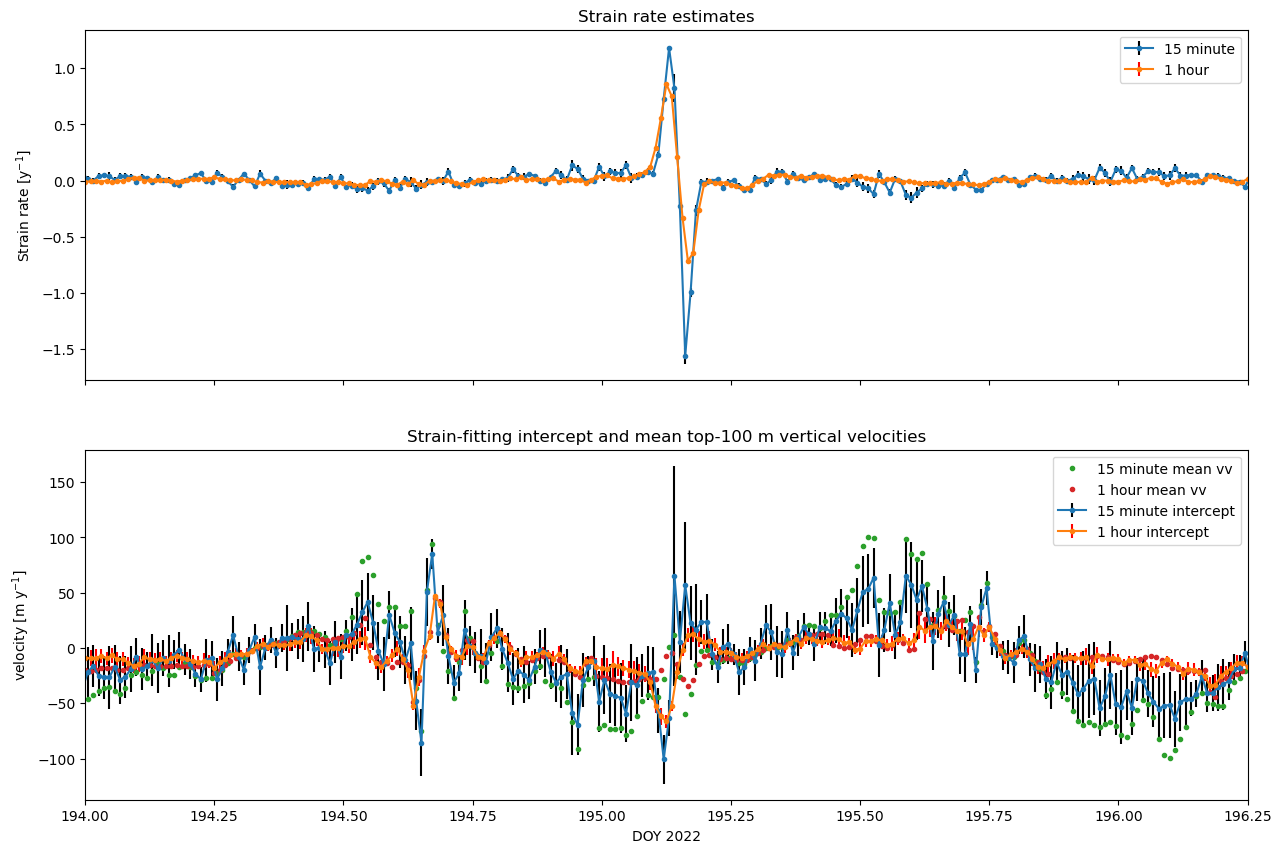

In [9]:
plot_fits(a11_15,a11_hour,[194,196.25])

## Load A13 data

In [10]:
ds_13_drain = ds_13.isel(time=range(4200,5200))
test = custom_profile(ds_13_drain.isel(attenuator_setting_pair=0).chirp,clip_threshold=1.2,min_chirps = 5,start=30000)
time_to_interp = pd.date_range("2022-07-09 12:00", "2022-07-19 12:00", freq="15min")
interp_profiles = test.interp(time=time_to_interp,method='linear')
interp_profiles['doy_decimal'] = interp_profiles.time.dt.dayofyear + (interp_profiles.time.dt.hour / 24) + (interp_profiles.time.dt.minute / 1440) + (interp_profiles.time.dt.second / 86400)


In [11]:
a13_15 = strain_metrics(interp_profiles, 24, 24,1,800)
a13_hour = strain_metrics(interp_profiles, 24, 24,4,800)
a13_2hour = strain_metrics(interp_profiles, 24, 24,8,800)

/home/jovyan/xapres_package/notebooks/test_notes/strain_rates/../../../xapres_package/ApRESDefs.py:654: RuntimeWarning: invalid value encountered in divide
  c = top/bottom
/home/jovyan/xapres_package/notebooks/test_notes/strain_rates/../../../xapres_package/ApRESDefs.py:654: RuntimeWarning: invalid value encountered in divide
  c = top/bottom
/home/jovyan/xapres_package/notebooks/test_notes/strain_rates/../../../xapres_package/ApRESDefs.py:654: RuntimeWarning: invalid value encountered in divide
  c = top/bottom


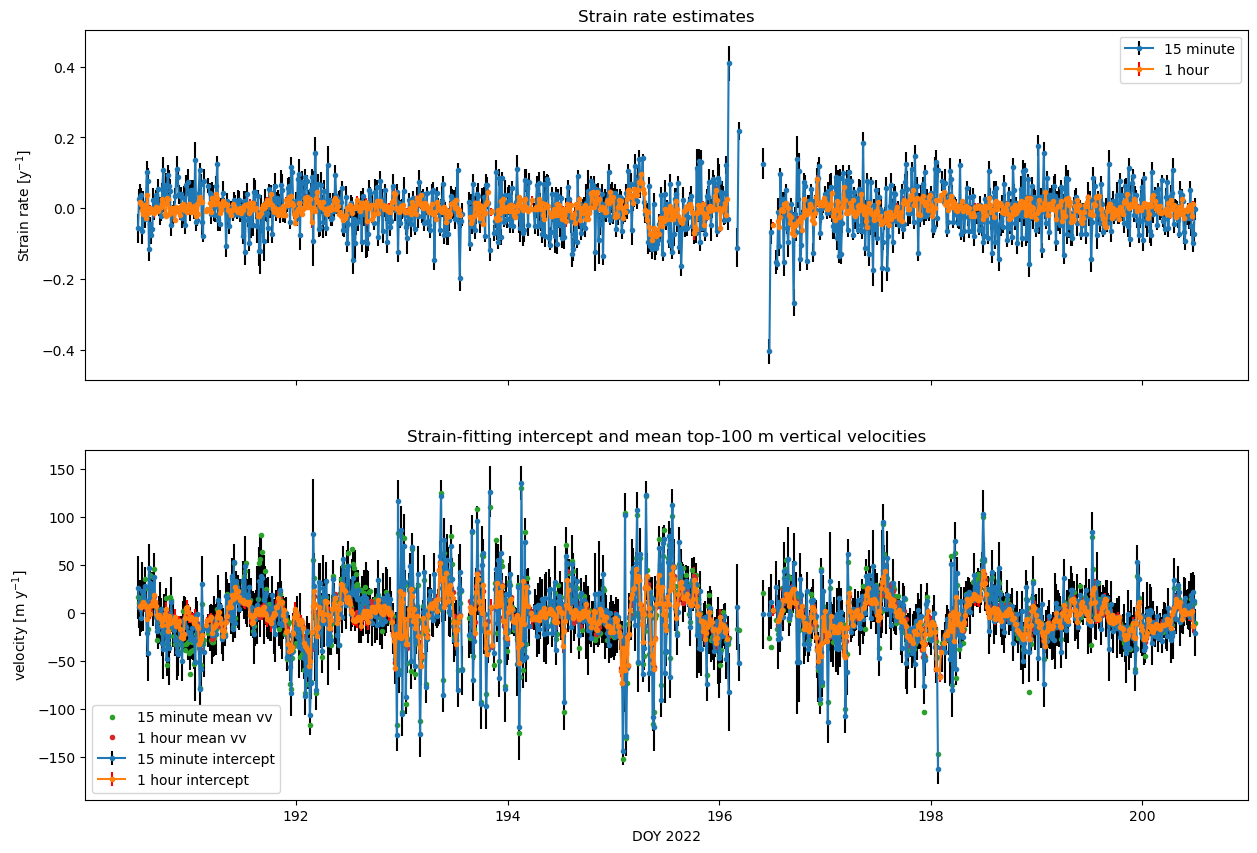

In [12]:
plot_fits(a13_15,a13_hour)

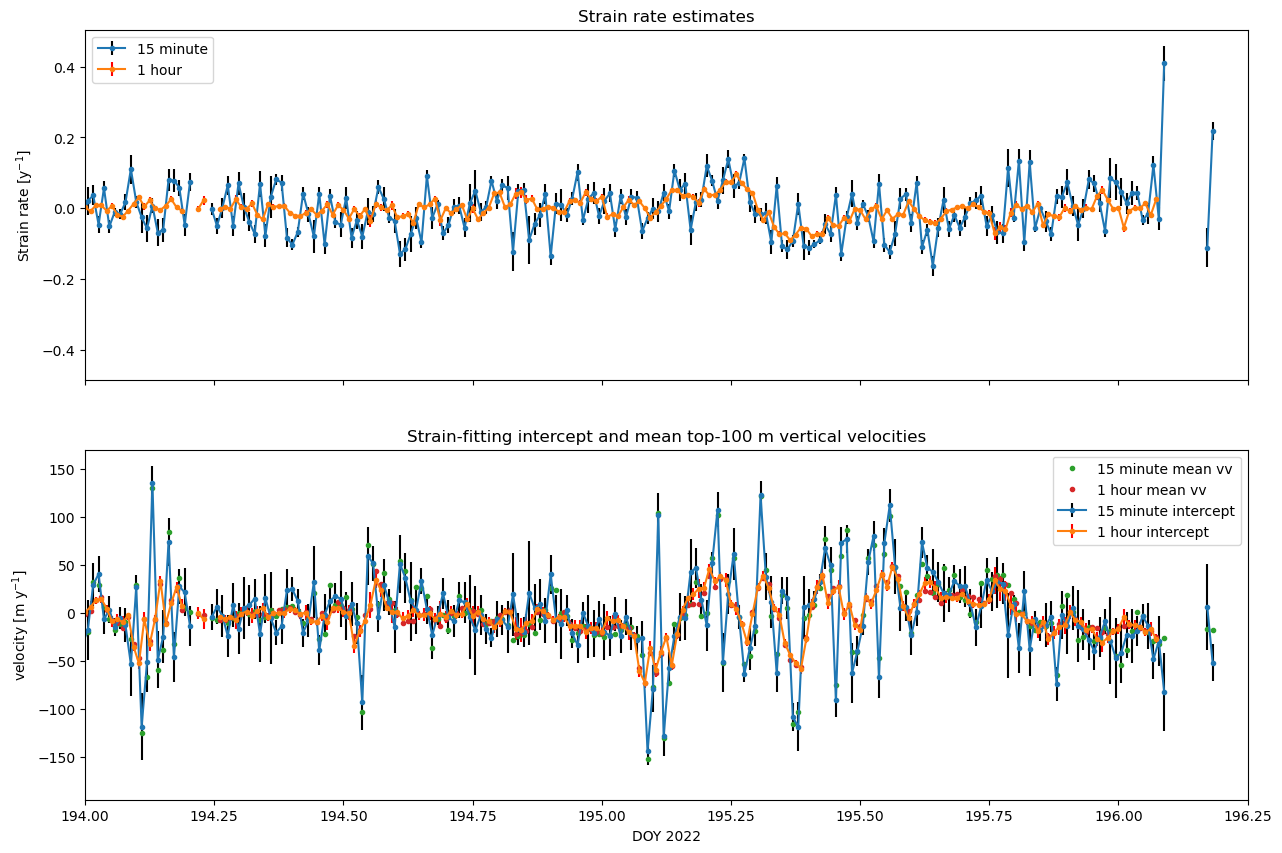

In [13]:
plot_fits(a13_15,a13_hour,[194,196.25])

## Load A14 data

In [14]:
ds_14_drain = ds_14.isel(time=range(4200,5200))
test = custom_profile(ds_14_drain.isel(attenuator_setting_pair=0).chirp,clip_threshold=1.2,min_chirps = 5,start=4000)
time_to_interp = pd.date_range("2022-07-09 12:00", "2022-07-19 12:00", freq="15min")
interp_profiles = test.interp(time=time_to_interp,method='linear')
interp_profiles['doy_decimal'] = interp_profiles.time.dt.dayofyear + (interp_profiles.time.dt.hour / 24) + (interp_profiles.time.dt.minute / 1440) + (interp_profiles.time.dt.second / 86400)


In [15]:
a14_15 = strain_metrics(interp_profiles, 80, 80,1,800)
a14_hour = strain_metrics(interp_profiles, 80, 80,4,800)
a14_2hour = strain_metrics(interp_profiles, 80, 80,8,800)


/home/jovyan/xapres_package/notebooks/test_notes/strain_rates/../../../xapres_package/ApRESDefs.py:654: RuntimeWarning: invalid value encountered in divide
  c = top/bottom
/home/jovyan/xapres_package/notebooks/test_notes/strain_rates/../../../xapres_package/ApRESDefs.py:654: RuntimeWarning: invalid value encountered in divide
  c = top/bottom
/home/jovyan/xapres_package/notebooks/test_notes/strain_rates/../../../xapres_package/ApRESDefs.py:654: RuntimeWarning: invalid value encountered in divide
  c = top/bottom


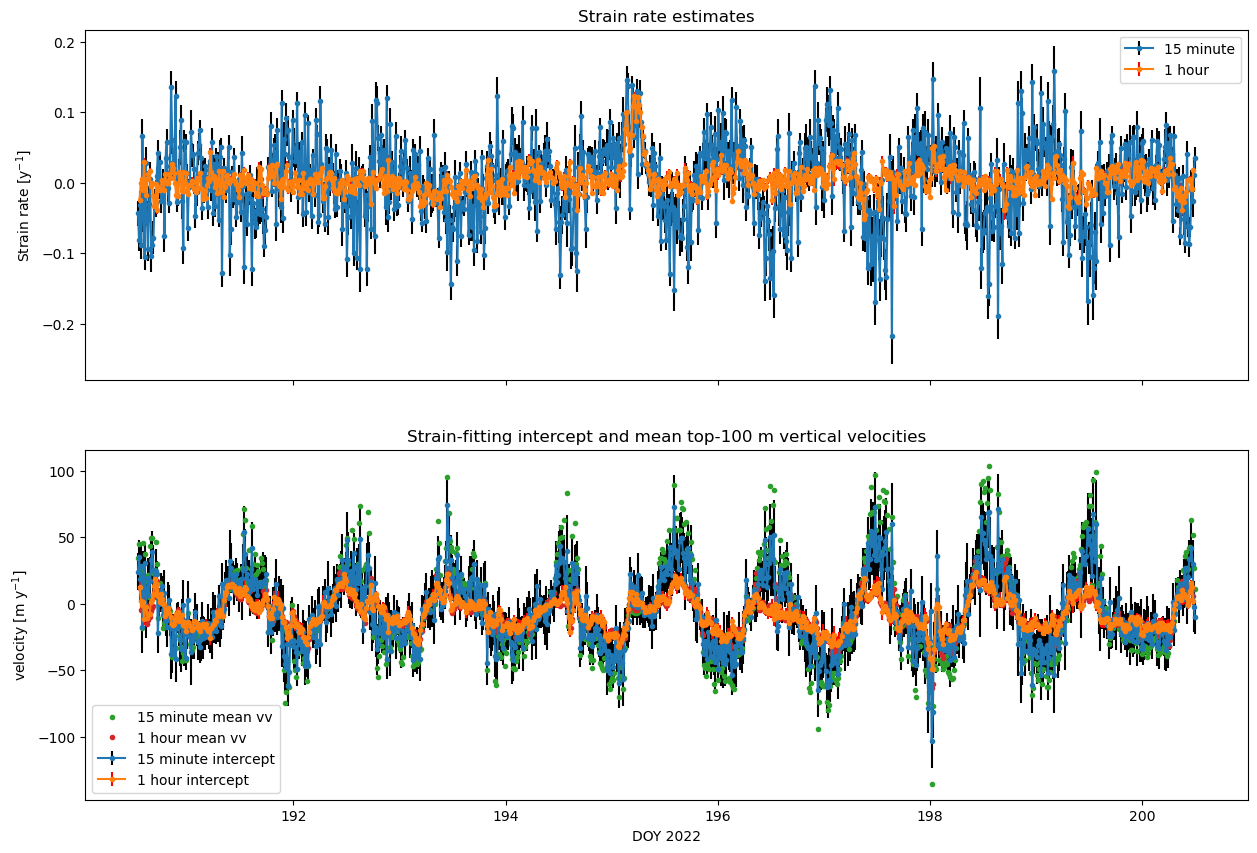

In [16]:
plot_fits(a14_15,a14_hour)

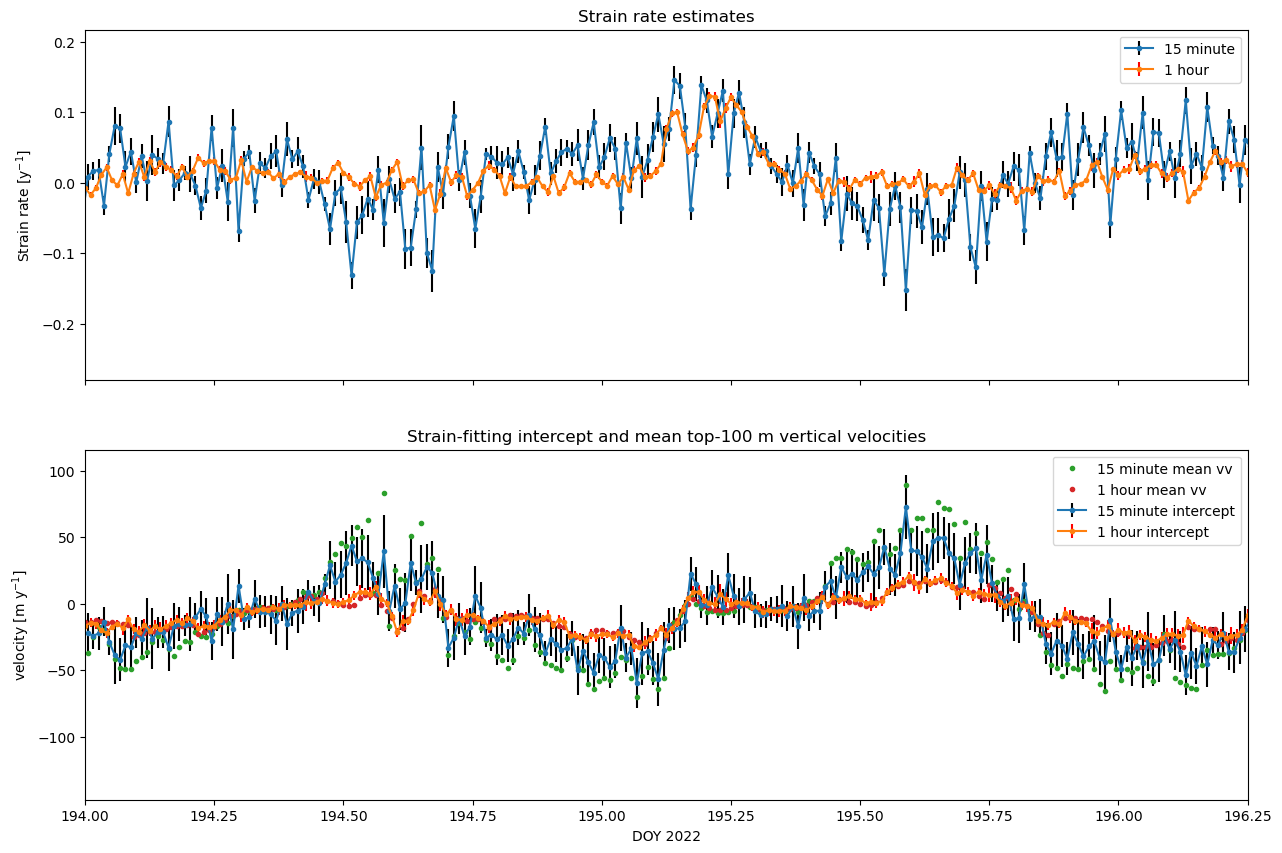

In [17]:
plot_fits(a14_15,a14_hour,[194,196.25])

## Load GPS data

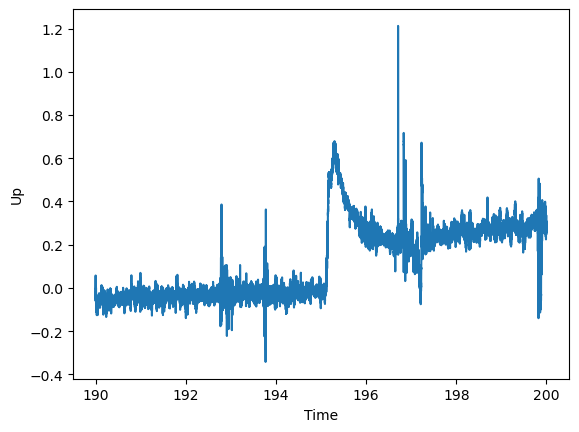

In [18]:
colnames = ['Time','East','North','Up','sigma_east','sigma_north','sigma_up']
data = pd.read_csv('sq11_YY_MM_DD_HR_MIN_SEC.txt', sep=" ", names=colnames, header=None)
#data['datetime']=  pd.to_datetime(
#                      data['Time'], unit='D', origin=pd.Timestamp('2021-12-31')
#                      )

data = data.set_index('Time')
gps_data = data.to_xarray()
gps_data.Up.plot(x='Time')

## Plot everything together

Text(0.5, 0, 'DOY 2022')

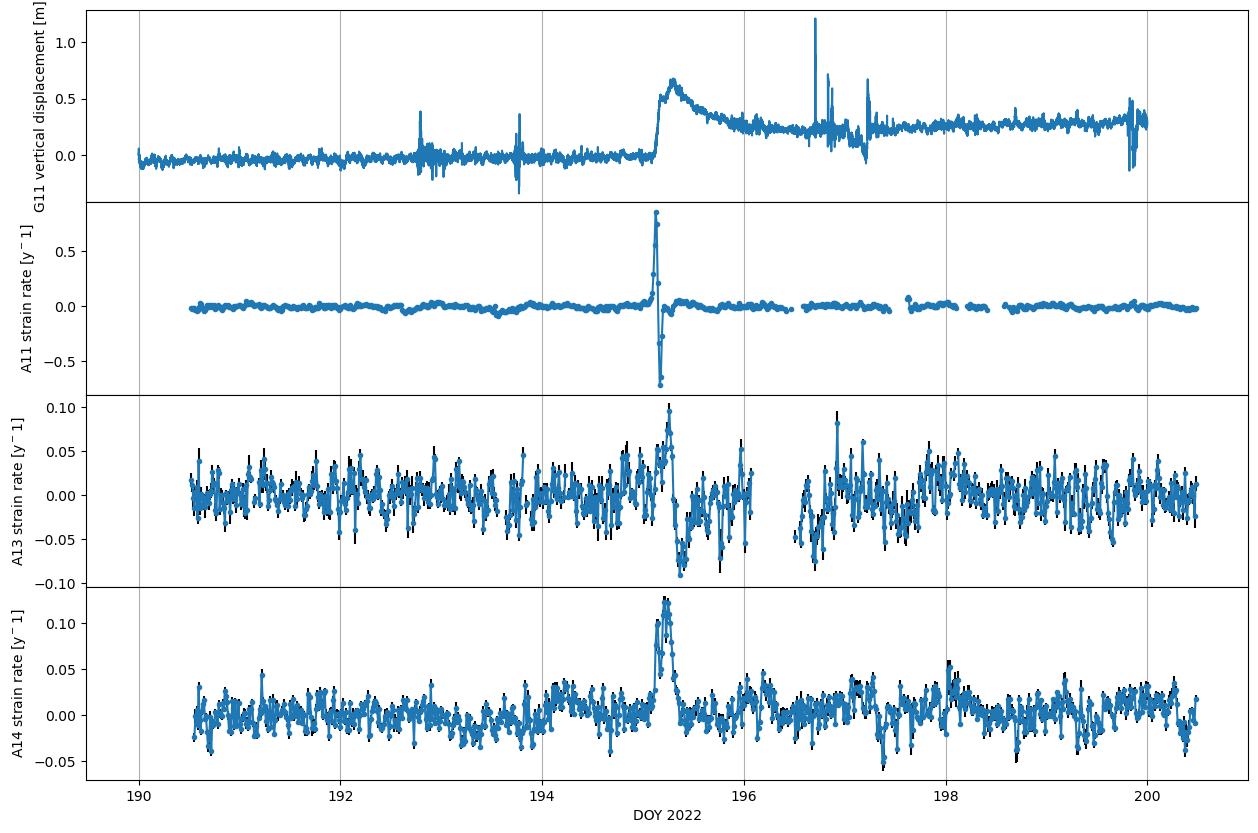

In [19]:
fig, axs = plt.subplots(nrows=4,figsize=(15,10),sharex=True)
gps_data.Up.plot(ax=axs[0],x='Time')
axs[0].grid(axis='x',which='both')
axs[0].set_ylabel('G11 vertical displacement [m]')

ds_list = [a11_hour,a13_hour,a14_hour]
#ds_list = [a11_15,a13_15,a14_15]
label_list = ['A11','A13','A14']
for i in range(3):
    ds_hour = ds_list[i]
    axs[i+1].errorbar(ds_hour.doy_decimal,ds_hour.slope,yerr=ds_hour.slope_err,marker='.',ecolor='k',label = label_list[i])
    axs[i+1].grid(axis='x',which='both')
    axs[i+1].set_ylabel(f'{label_list[i]} strain rate [y$^{-1}$]')
plt.subplots_adjust(wspace=0, hspace=0)
axs[-1].set_xlabel('DOY 2022')

Text(0.5, 0, 'DOY 2022')

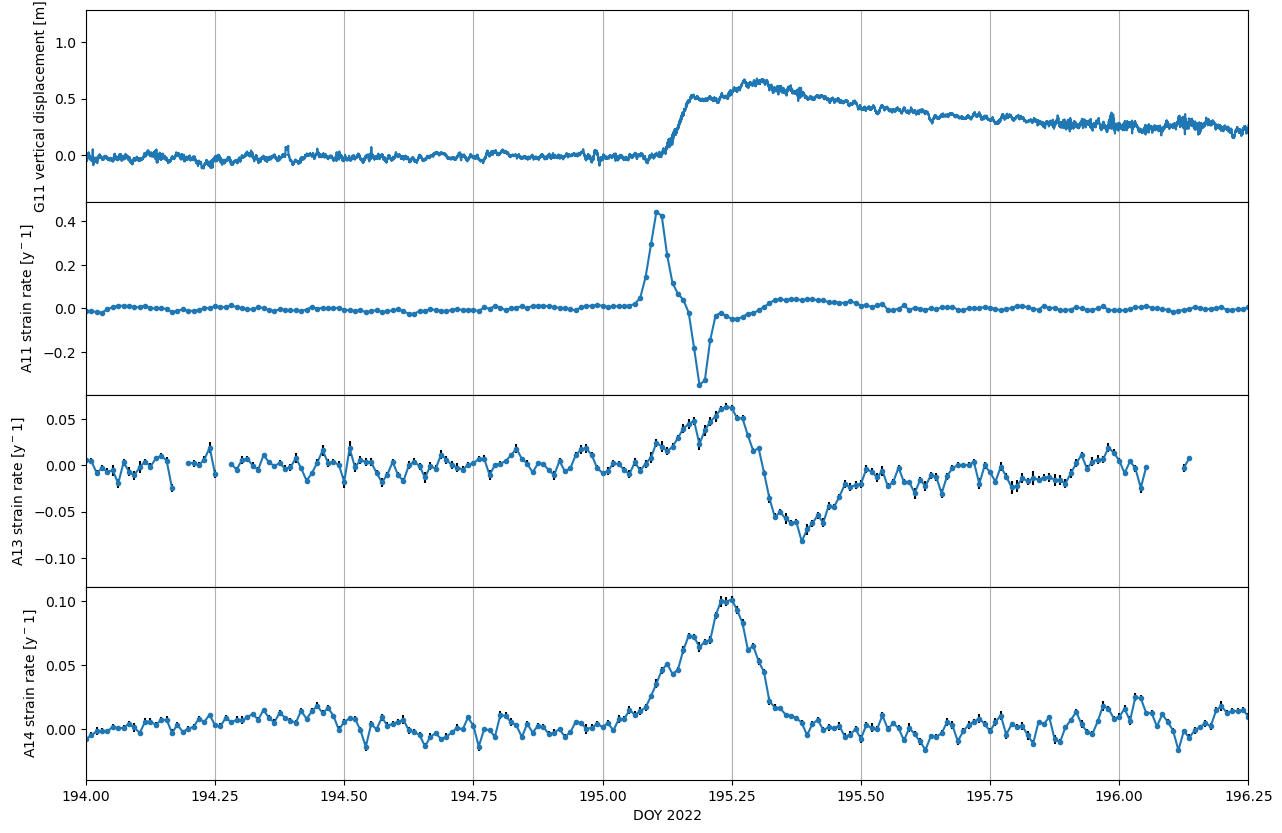

In [20]:
fig, axs = plt.subplots(nrows=4,figsize=(15,10),sharex=True)
gps_data.Up.plot(ax=axs[0],x='Time')
axs[0].grid(axis='x',which='both')
axs[0].set_xlim([194,196.25])
axs[0].set_ylabel('G11 vertical displacement [m]')

ds_list = [a11_2hour,a13_2hour,a14_2hour]
#ds_list = [a11_15,a13_15,a14_15]
label_list = ['A11','A13','A14']
for i in range(3):
    ds_hour = ds_list[i]
    axs[i+1].errorbar(ds_hour.doy_decimal,ds_hour.slope,yerr=ds_hour.slope_err,marker='.',ecolor='k',label = label_list[i])
    axs[i+1].grid(axis='x',which='both')
    axs[i+1].set_ylabel(f'{label_list[i]} strain rate [y$^{-1}$]')
plt.subplots_adjust(wspace=0, hspace=0)
axs[-1].set_xlabel('DOY 2022')

Trying to plot vv

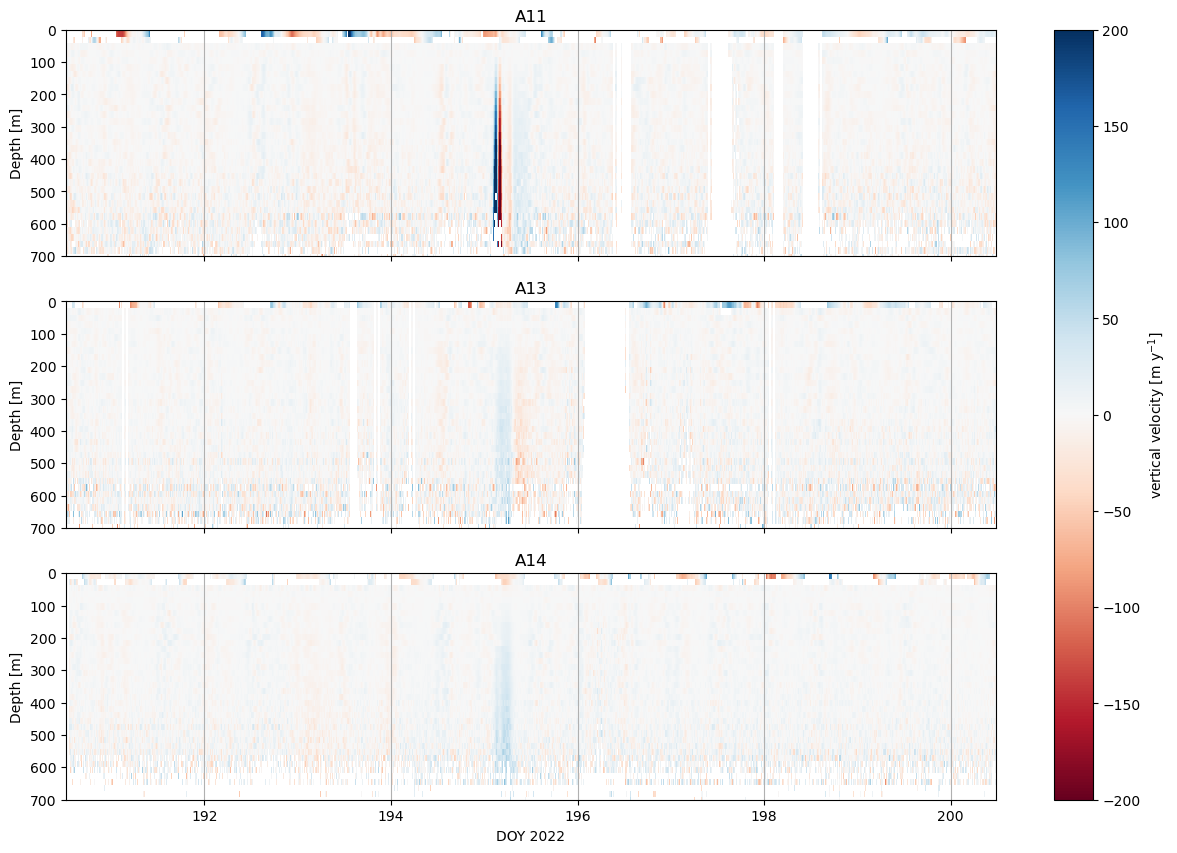

In [21]:
fig, axs = plt.subplots(nrows=3,figsize=(15,10),sharex=True)

ds_list = [a11_hour,a13_hour,a14_hour]
#ds_list = [a11_15,a13_15,a14_15]
label_list = ['A11','A13','A14']
for i in range(3):
    ds_hour = ds_list[i]
    vv = convert_to_doy(ds_hour.vv_adjust)
    im = vv.plot(ax=axs[i],x='doy_decimal',add_colorbar=False,vmin=-200,vmax=200,cmap='RdBu')
    axs[i].invert_yaxis()
    axs[i].set_title('')
    axs[i].set_xlabel('')
    axs[i].set_title(label_list[i])
    axs[i].set_ylim([700,0])
    #axs[i].set_xlim([194,196.25])

    #axs[i].errorbar(ds_hour.doy_decimal,ds_hour.slope,yerr=ds_hour.slope_err,marker='.',ecolor='k',label = label_list[i])
    axs[i].grid(axis='x',which='both')
    #axs[i].set_ylabel(f'{label_list[i]} strain rate [y$^{-1}$]')
plt.subplots_adjust(wspace=0, hspace=0.2)
axs[-1].set_xlabel('DOY 2022')
cb = fig.colorbar(im, ax=axs, orientation='vertical',label =  'vertical velocity [m y$^{-1}$]')


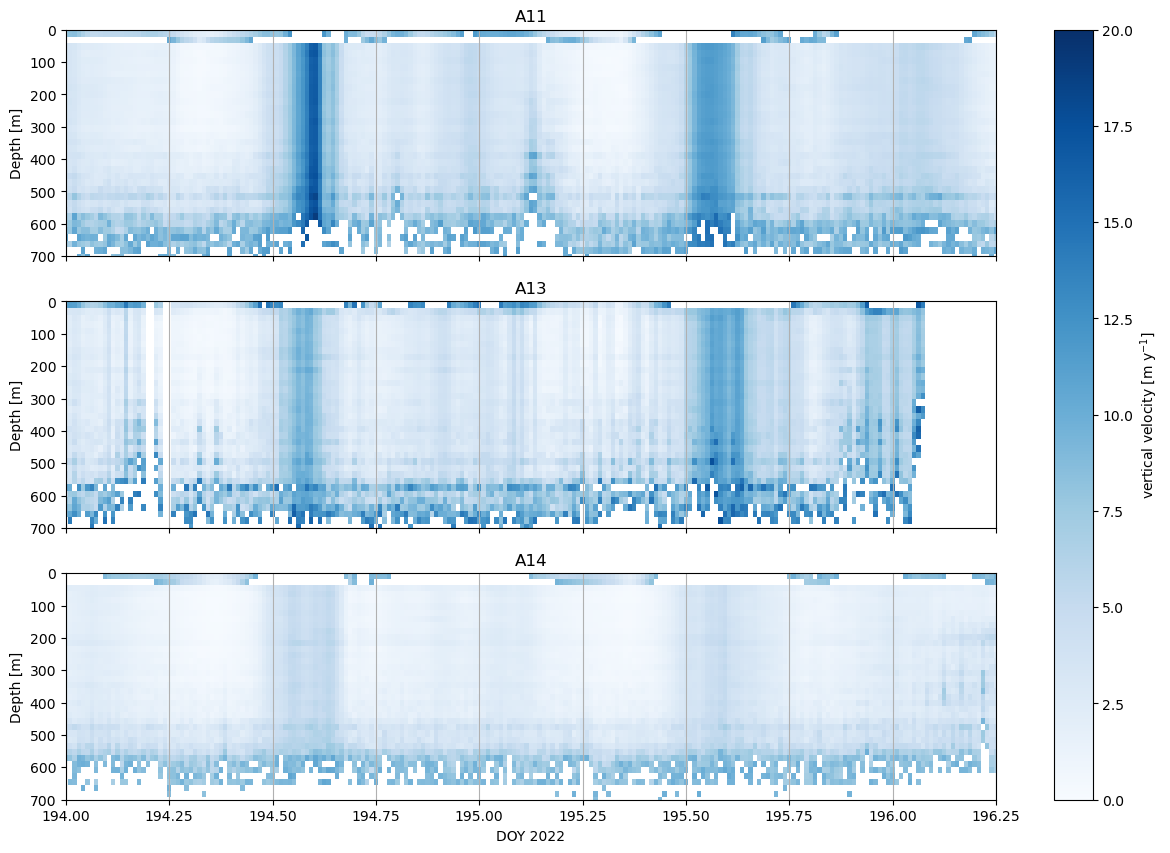

In [22]:
fig, axs = plt.subplots(nrows=3,figsize=(15,10),sharex=True)

ds_list = [a11_hour,a13_hour,a14_hour]
#ds_list = [a11_15,a13_15,a14_15]
label_list = ['A11','A13','A14']
for i in range(3):
    ds_hour = ds_list[i]
    vv = convert_to_doy(ds_hour.vv_adjust_err)
    im = vv.plot(ax=axs[i],x='doy_decimal',add_colorbar=False,vmin=0,vmax=20,cmap='Blues')
    axs[i].invert_yaxis()
    axs[i].set_title('')
    axs[i].set_xlabel('')
    axs[i].set_title(label_list[i])
    axs[i].set_ylim([700,0])
    axs[i].set_xlim([194,196.25])

    #axs[i].errorbar(ds_hour.doy_decimal,ds_hour.slope,yerr=ds_hour.slope_err,marker='.',ecolor='k',label = label_list[i])
    axs[i].grid(axis='x',which='both')
    #axs[i].set_ylabel(f'{label_list[i]} strain rate [y$^{-1}$]')
plt.subplots_adjust(wspace=0, hspace=0.2)
axs[-1].set_xlabel('DOY 2022')
cb = fig.colorbar(im, ax=axs, orientation='vertical',label =  'vertical velocity [m y$^{-1}$]')


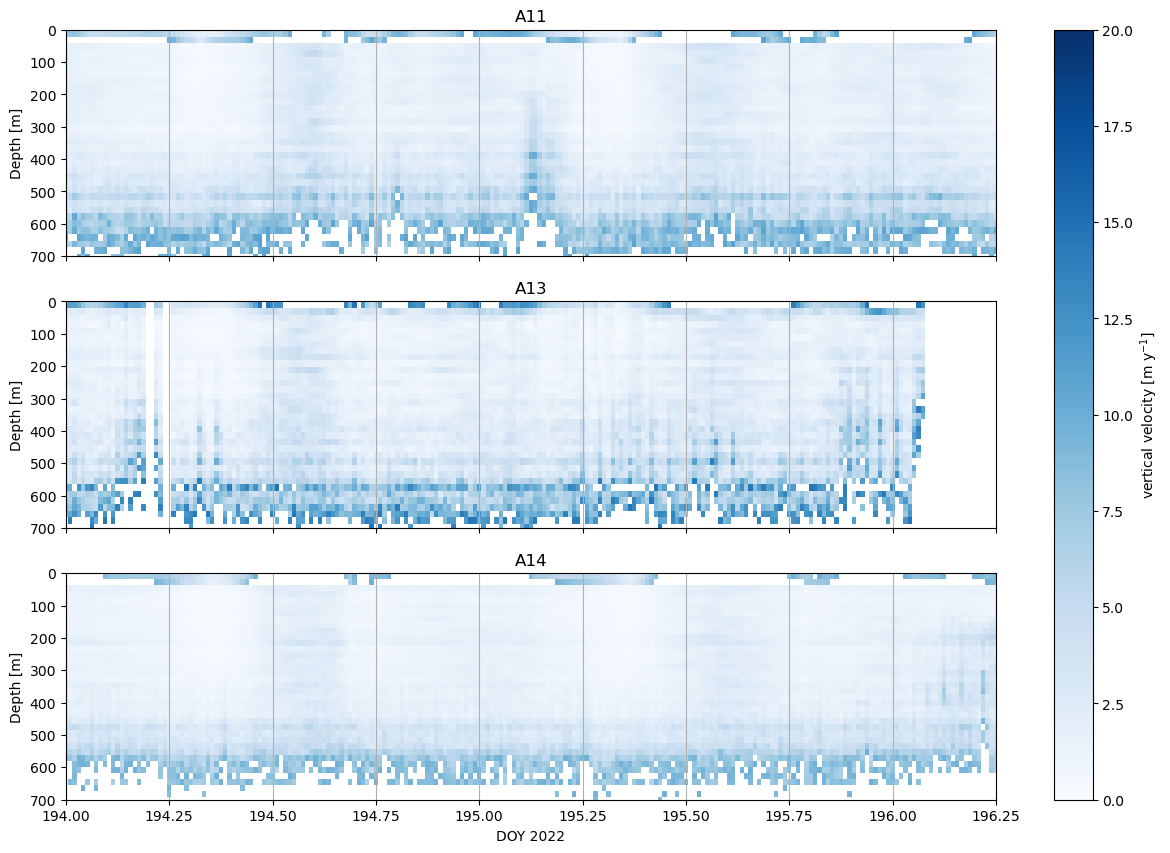

In [23]:
fig, axs = plt.subplots(nrows=3,figsize=(15,10),sharex=True)

ds_list = [a11_hour,a13_hour,a14_hour]
#ds_list = [a11_15,a13_15,a14_15]
label_list = ['A11','A13','A14']
for i in range(3):
    ds_hour = ds_list[i]
    vv = convert_to_doy(ds_hour.err)
    im = vv.plot(ax=axs[i],x='doy_decimal',add_colorbar=False,vmin=0,vmax=20,cmap='Blues')
    axs[i].invert_yaxis()
    axs[i].set_title('')
    axs[i].set_xlabel('')
    axs[i].set_title(label_list[i])
    axs[i].set_ylim([700,0])
    axs[i].set_xlim([194,196.25])

    #axs[i].errorbar(ds_hour.doy_decimal,ds_hour.slope,yerr=ds_hour.slope_err,marker='.',ecolor='k',label = label_list[i])
    axs[i].grid(axis='x',which='both')
    #axs[i].set_ylabel(f'{label_list[i]} strain rate [y$^{-1}$]')
plt.subplots_adjust(wspace=0, hspace=0.2)
axs[-1].set_xlabel('DOY 2022')
cb = fig.colorbar(im, ax=axs, orientation='vertical',label =  'vertical velocity [m y$^{-1}$]')


## Let's look at individual velocity profiles

In [56]:
ts = a14_15.isel(time=range(406,503))

In [57]:
ts

<xarray.Dataset> Size: 292kB
Dimensions:        (time: 97, profile_range: 74)
Coordinates:
  * time           (time) datetime64[ns] 776B 2022-07-13T17:37:30 ... 2022-07...
  * profile_range  (profile_range) float64 592B 9.347 28.04 ... 1.374e+03
    degree         int64 8B 1
Data variables:
    vv             (time, profile_range) float64 57kB -40.22 -22.23 ... nan nan
    err            (time, profile_range) float64 57kB 11.11 12.93 ... nan nan
    slope          (time) float64 776B 0.04319 -0.01819 ... -0.1199 -0.004212
    intercept      (time) float64 776B -24.46 -17.13 5.976 ... 38.23 41.69 17.72
    fit            (time, profile_range) float64 57kB -24.05 -23.25 ... 11.93
    slope_err      (time) float64 776B 0.018 0.01774 0.02758 ... 0.02421 0.02154
    int_err        (time) float64 776B 14.38 14.17 22.02 ... 15.19 19.34 17.2
    vv_adjust      (time, profile_range) float64 57kB -25.81 -7.827 ... nan nan
    vv_adjust_err  (time, profile_range) float64 57kB 11.12 12.94 ... nan nan
    doy_decimal    (time) float64 776B 194.7 194.7 194.8 ... 195.7 195.7 195.7

In [58]:
ts.hvplot.errorbars(y='vv_adjust',yerr1='vv_adjust_err',groupby="time",ylabel='vertical velocity (m/y)',xlim=[0,1200],ylim=[-200,200],widget_type="scrubber",
    widget_location="bottom")



Column
    [0] HoloViews(DynamicMap, height=300, sizing_mode='fixed', widget_location='bottom', widget_type='scrubber', width=700)
    [1] WidgetBox(align=('center', 'end'))
        [0] Player(end=96, width=550)

Velocity animation

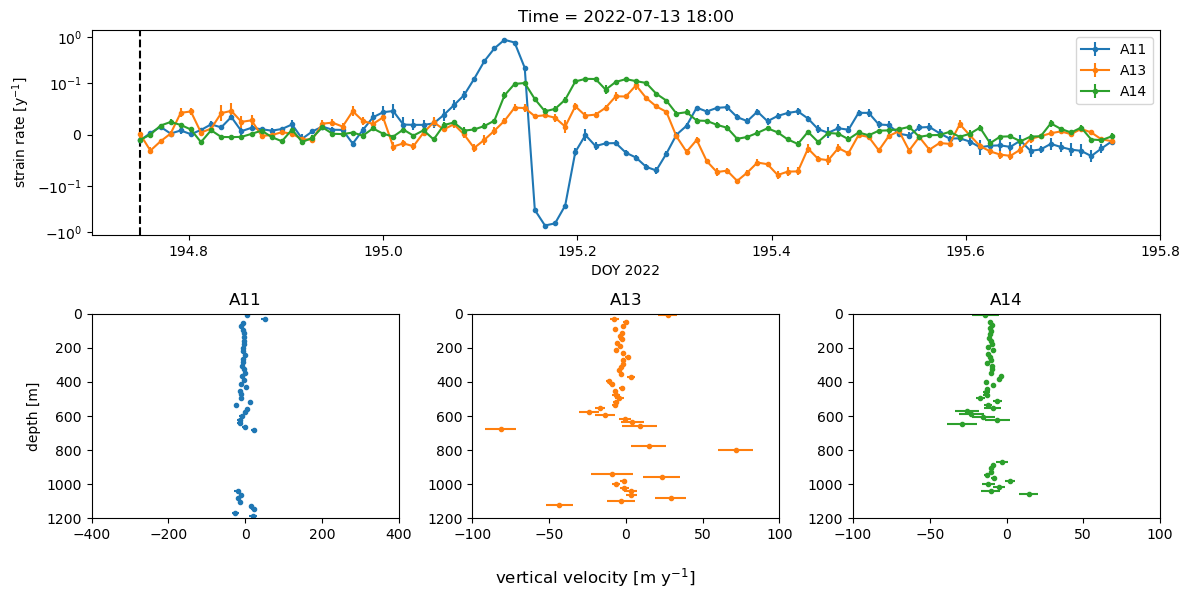

In [153]:
import matplotlib.pyplot as plt
import matplotlib.animation
import numpy as np


fig = plt.figure(figsize=(12, 6))
ax1 = plt.subplot(2,3,4)
ax2 = plt.subplot(2,3,5,sharey = ax1)
ax3 = plt.subplot(2,3,6,sharey = ax1)
ax4 = plt.subplot(2,1,1)
axes = [ax1, ax2, ax3, ax4]

a11_subset = a11_hour.isel(time=range(406,503))
a13_subset = a13_hour.isel(time=range(406,503))
a14_subset = a14_hour.isel(time=range(406,503))

times = a11_subset.doy_decimal.values
a11_strain = ax4.errorbar(a11_subset.doy_decimal,a11_subset.slope,yerr=a11_subset.slope_err,marker='.',label='A11')
a13_strain = ax4.errorbar(a13_subset.doy_decimal,a13_subset.slope,yerr=a13_subset.slope_err,marker='.',label='A13')
a14_strain = ax4.errorbar(a14_subset.doy_decimal,a14_subset.slope,yerr=a14_subset.slope_err,marker='.',label='A14')
ax4.legend()
ax4.set_yscale('symlog', linthresh=0.1)
ax4.set_xlabel('DOY 2022')
ax4.set_ylabel('strain rate [y$^{-1}$]')
time_line = ax4.axvline(times[0],color = 'black',linestyle = '--')
title_str = str(a11_subset.time.values[0])[:16].replace('T',' ')
ax4.set_title(f'Time = {title_str}')

ax1.errorbar(a11_subset.vv.isel(time=0),a11_subset.profile_range,yerr=None,xerr=a11_subset.err.isel(time=0),linestyle='None',marker='.',color = 'tab:blue')
ax1.set_xlim([-400,400])
ax1.set_ylim([1200,0])
ax1.set_title('A11')
ax1.set_ylabel('depth [m]')

ax2.errorbar(a13_subset.vv.isel(time=0),a13_subset.profile_range,yerr=None,xerr=a13_subset.err.isel(time=0),linestyle='None',marker='.',color = 'tab:orange')
ax2.set_xlim([-100,100])
ax2.set_ylim([1200,0])
ax2.set_title('A13')

ax3.errorbar(a14_subset.vv.isel(time=0),a14_subset.profile_range,yerr=None,xerr=a14_subset.err.isel(time=0),linestyle='None',marker='.',color = 'tab:green')
ax3.set_xlim([-100,100])
ax3.set_ylim([1200,0])
ax3.set_title('A14')

fig.supxlabel('vertical velocity [m y$^{-1}$]')
plt.tight_layout()
#l, = ax1.plot([],[])
#l1, = ax2.plot([],[])

def animate(i):
    time_line.set_xdata([times[i],times[i]])
    title_str = str(a11_subset.time.values[i])[:16].replace('T',' ')
    ax4.set_title(f'Time = {title_str}')
    
    ax1.clear()
    ax1.errorbar(a11_subset.vv.isel(time=i),a11_subset.profile_range,yerr=None,xerr=a11_subset.err.isel(time=i),linestyle='None',marker='.',color = 'tab:blue')
    ax1.set_xlim([-400,400])
    ax1.set_ylim([1200,0])
    ax1.set_title('A11')
    ax1.set_ylabel('depth [m]')

    ax2.clear()
    ax2.errorbar(a13_subset.vv.isel(time=i),a13_subset.profile_range,yerr=None,xerr=a13_subset.err.isel(time=i),linestyle='None',marker='.',color = 'tab:orange')
    ax2.set_xlim([-100,100])
    ax2.set_ylim([1200,0])
    ax2.set_title('A13')

    ax3.clear()
    ax3.errorbar(a14_subset.vv.isel(time=i),a14_subset.profile_range,yerr=None,xerr=a14_subset.err.isel(time=i),linestyle='None',marker='.',color = 'tab:green')
    ax3.set_xlim([-100,100])
    ax3.set_ylim([1200,0])
    ax3.set_title('A14')

ani = matplotlib.animation.FuncAnimation(fig, animate, frames=len(times))

from IPython.display import HTML
#HTML(ani.to_jshtml())
HTML(ani.to_html5_video())


Velocity animation with adjusted velocities

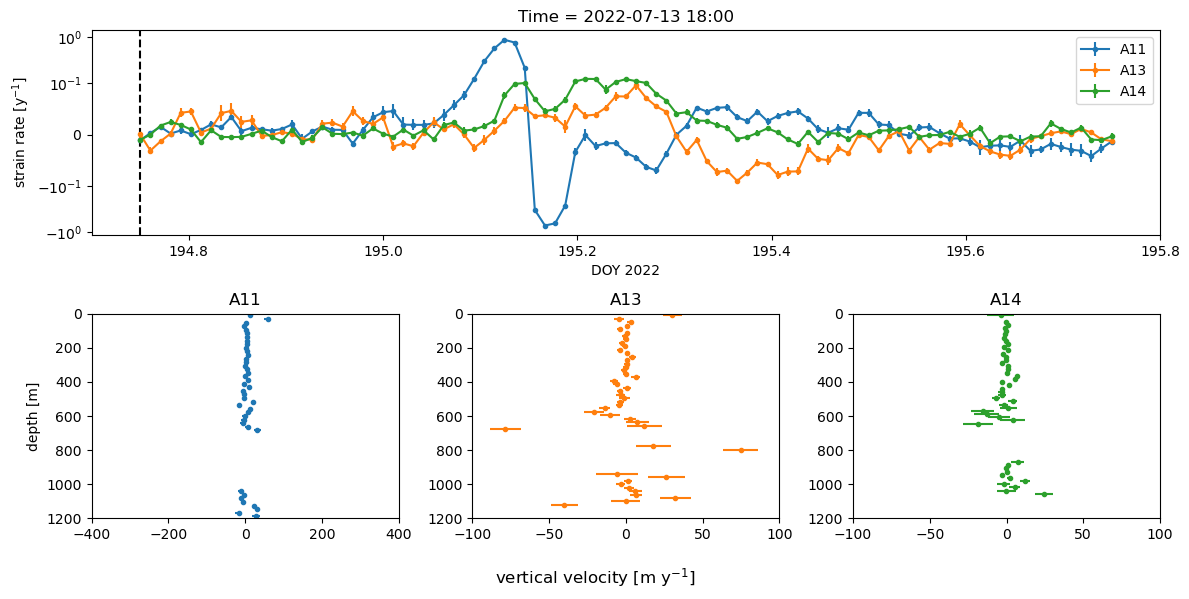

In [154]:
import matplotlib.pyplot as plt
import matplotlib.animation
import numpy as np


fig = plt.figure(figsize=(12, 6))
ax1 = plt.subplot(2,3,4)
ax2 = plt.subplot(2,3,5,sharey = ax1)
ax3 = plt.subplot(2,3,6,sharey = ax1)
ax4 = plt.subplot(2,1,1)
axes = [ax1, ax2, ax3, ax4]

a11_subset = a11_hour.isel(time=range(406,503))
a13_subset = a13_hour.isel(time=range(406,503))
a14_subset = a14_hour.isel(time=range(406,503))

times = a11_subset.doy_decimal.values
a11_strain = ax4.errorbar(a11_subset.doy_decimal,a11_subset.slope,yerr=a11_subset.slope_err,marker='.',label='A11')
a13_strain = ax4.errorbar(a13_subset.doy_decimal,a13_subset.slope,yerr=a13_subset.slope_err,marker='.',label='A13')
a14_strain = ax4.errorbar(a14_subset.doy_decimal,a14_subset.slope,yerr=a14_subset.slope_err,marker='.',label='A14')
ax4.legend()
ax4.set_yscale('symlog', linthresh=0.1)
ax4.set_xlabel('DOY 2022')
ax4.set_ylabel('strain rate [y$^{-1}$]')
time_line = ax4.axvline(times[0],color = 'black',linestyle = '--')
title_str = str(a11_subset.time.values[0])[:16].replace('T',' ')
ax4.set_title(f'Time = {title_str}')

ax1.errorbar(a11_subset.vv_adjust.isel(time=0),a11_subset.profile_range,yerr=None,xerr=a11_subset.vv_adjust_err.isel(time=0),linestyle='None',marker='.',color = 'tab:blue')
ax1.set_xlim([-400,400])
ax1.set_ylim([1200,0])
ax1.set_title('A11')
ax1.set_ylabel('depth [m]')

ax2.errorbar(a13_subset.vv_adjust.isel(time=0),a13_subset.profile_range,yerr=None,xerr=a13_subset.vv_adjust_err.isel(time=0),linestyle='None',marker='.',color = 'tab:orange')
ax2.set_xlim([-100,100])
ax2.set_ylim([1200,0])
ax2.set_title('A13')

ax3.errorbar(a14_subset.vv_adjust.isel(time=0),a14_subset.profile_range,yerr=None,xerr=a14_subset.vv_adjust_err.isel(time=0),linestyle='None',marker='.',color = 'tab:green')
ax3.set_xlim([-100,100])
ax3.set_ylim([1200,0])
ax3.set_title('A14')

fig.supxlabel('vertical velocity [m y$^{-1}$]')
plt.tight_layout()
#l, = ax1.plot([],[])
#l1, = ax2.plot([],[])

def animate(i):
    time_line.set_xdata([times[i],times[i]])
    title_str = str(a11_subset.time.values[i])[:16].replace('T',' ')
    ax4.set_title(f'Time = {title_str}')
    
    ax1.clear()
    ax1.errorbar(a11_subset.vv_adjust.isel(time=i),a11_subset.profile_range,yerr=None,xerr=a11_subset.vv_adjust_err.isel(time=i),linestyle='None',marker='.',color = 'tab:blue')
    ax1.set_xlim([-400,400])
    ax1.set_ylim([1200,0])
    ax1.set_title('A11')
    ax1.set_ylabel('depth [m]')

    ax2.clear()
    ax2.errorbar(a13_subset.vv_adjust.isel(time=i),a13_subset.profile_range,yerr=None,xerr=a13_subset.vv_adjust_err.isel(time=i),linestyle='None',marker='.',color = 'tab:orange')
    ax2.set_xlim([-100,100])
    ax2.set_ylim([1200,0])
    ax2.set_title('A13')

    ax3.clear()
    ax3.errorbar(a14_subset.vv_adjust.isel(time=i),a14_subset.profile_range,yerr=None,xerr=a14_subset.vv_adjust_err.isel(time=i),linestyle='None',marker='.',color = 'tab:green')
    ax3.set_xlim([-100,100])
    ax3.set_ylim([1200,0])
    ax3.set_title('A14')

ani = matplotlib.animation.FuncAnimation(fig, animate, frames=len(times))

from IPython.display import HTML
#HTML(ani.to_jshtml())
HTML(ani.to_html5_video())
